In [ ]:
!pip install gdown

In [ ]:
import gdown

file_url = 'https://drive.google.com/uc?export=download&id=1cmL_d8C6E2wS8BCHpJZXtj5GYLLal_xu'
output_file = 'Keypoints_dataset.zip'
gdown.download(file_url, output_file, quiet=False)

  3%|▎         | 235M/7.24G [00:19<01:07, 104MB/s]

In [3]:
import json

root_path = '/teamspace/studios/this_studio/Tennis-Analysis-system/fine_tuning'

with open(root_path + '/data/Keypoints_dataset/data_train.json', 'r') as file:
    data = json.load(file)

In [4]:
data[0]

{'id': 'PuXlxKdUIes_2450',
 'metric': 0.28256459215943674,
 'kps': [[378, 186],
  [905, 184],
  [242, 566],
  [1058, 564],
  [445, 185],
  [345, 566],
  [839, 185],
  [956, 564],
  [428, 247],
  [858, 246],
  [377, 445],
  [919, 443],
  [643, 247],
  [648, 444]]}

In [5]:
len(data[0]['kps']) # 14 keypoints each one consist of (x, y) Values 

14

* Example of tennis keypoints 

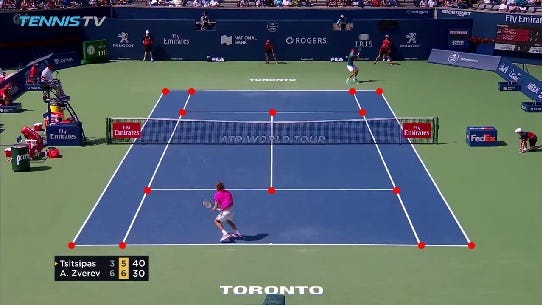

# Ball Analysis

In [2]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

In [3]:
with open('Tennis-Analysis-system/tracker_stubs/ball_detections.pkl', 'rb') as f:
    ball_positions = pickle.load(f)

In [4]:
ball_positions = [x.get(1,[]) for x in ball_positions]
# convert the list into pandas dataframe
df_ball_positions = pd.DataFrame(ball_positions,columns=['x1','y1','x2','y2'])

# interpolate the missing values
df_ball_positions = df_ball_positions.interpolate()
df_ball_positions = df_ball_positions.bfill()

In [5]:
df_ball_positions['mid_y'] = (df_ball_positions['y1'] + df_ball_positions['y2'])/2
df_ball_positions['mid_y_rolling_mean'] = df_ball_positions['mid_y'].rolling(window=5, min_periods=1, center=False).mean()


df_ball_positions['mid_x'] = (df_ball_positions['x1'] + df_ball_positions['x2'])/2
df_ball_positions['mid_x_rolling_mean'] = df_ball_positions['mid_x'].rolling(window=5, min_periods=1, center=False).mean()

In [6]:
df_ball_positions.head(5)

,x1,y1,x2,y2,mid_y,mid_y_rolling_mean,mid_x,mid_x_rolling_mean
0,892.697876,617.372314,911.343262,636.704102,627.038208,627.038208,902.020569,902.020569
1,892.697876,617.372314,911.343262,636.704102,627.038208,627.038208,902.020569,902.020569
2,878.352246,631.429956,896.589722,650.362854,640.896405,631.657607,887.470984,897.170707
3,864.006616,645.487598,881.836182,664.021606,654.754602,637.431856,872.921399,891.108380
4,849.660986,659.545239,867.082642,677.680359,668.612799,643.668044,858.371814,884.561067


In [7]:
df_ball_positions.describe() 

,x1,y1,x2,y2,mid_y,mid_y_rolling_mean,mid_x,mid_x_rolling_mean
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,904.970801,446.015286,919.358586,461.527622,453.771454,457.576989,912.164693,909.472425
std,201.398849,175.511314,201.685248,177.287416,176.394815,174.237127,201.536141,199.441546
min,621.060608,204.174408,637.549988,218.580414,211.377411,232.847423,629.305298,634.576022
25%,731.109344,290.868696,746.265266,304.950011,298.073986,299.418714,739.646381,739.316302
50%,877.582748,395.896396,890.671460,411.480896,403.688646,411.520742,884.127104,883.895328
75%,1036.857391,617.372314,1053.059433,636.363525,627.038208,627.038208,1044.958412,1018.435133
max,1293.919189,787.457642,1313.399048,804.197876,795.827759,775.414299,1303.659119,1295.679077


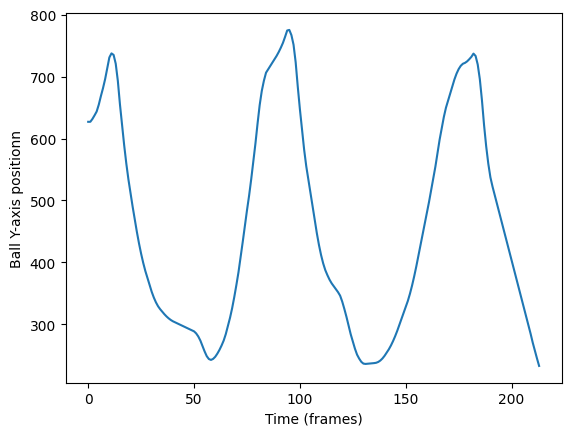

In [8]:
plt.plot(df_ball_positions['mid_y_rolling_mean']) # Plot chnage of Ball move in y-axis (above and down)
plt.xlabel('Time (frames)')
plt.ylabel('Ball Y-axis positionn')
plt.show()
# Chnage of Dican position axis (Means a ball is hit)

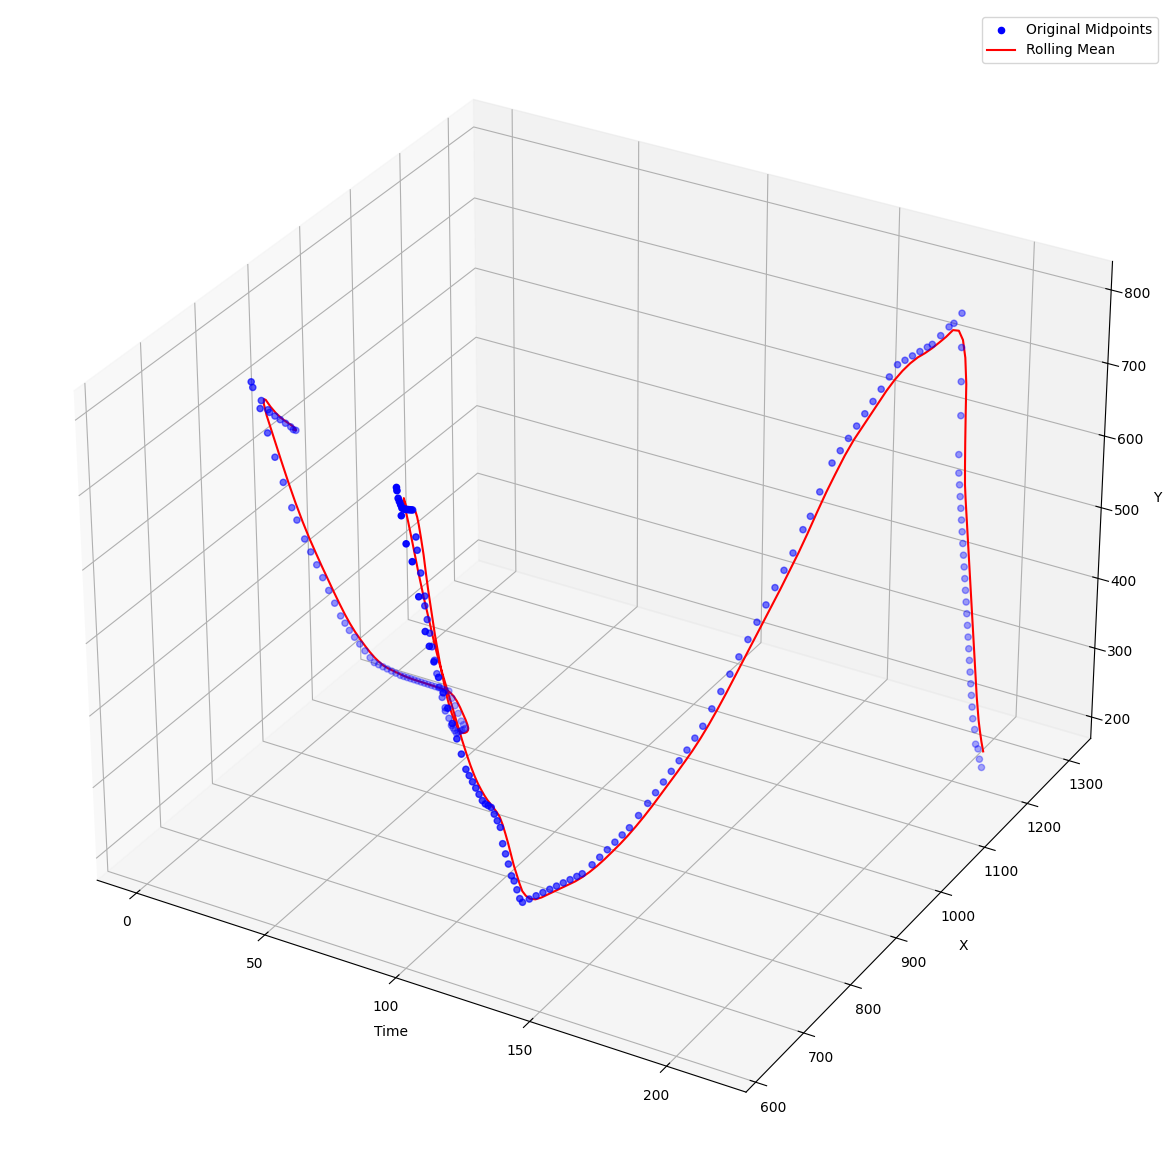

In [9]:
# Create a time axis
df_ball_positions['time'] = np.arange(len(df_ball_positions))

# Plotting the 3D plot
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_ball_positions['time'], df_ball_positions['mid_x'], df_ball_positions['mid_y'], color='b', label='Original Midpoints')
ax.plot(df_ball_positions['time'], df_ball_positions['mid_x_rolling_mean'], df_ball_positions['mid_y_rolling_mean'], color='r', label='Rolling Mean')
ax.set_xlabel('Time')
ax.set_ylabel('X')
ax.set_zlabel('Y')
ax.legend()
plt.show()

In [10]:
df_ball_positions['delta_y'] = df_ball_positions['mid_y_rolling_mean'].diff() # Different between two consecutive Y-Mean-axis row wais

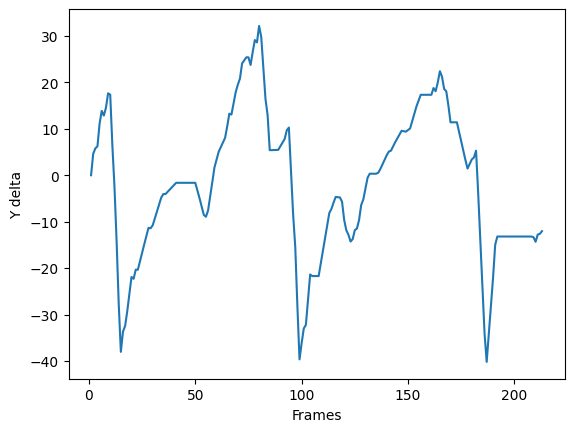

In [11]:
plt.plot(df_ball_positions['delta_y'])
plt.ylabel('Y delta')
plt.xlabel('Frames')
plt.show() # The differents start an almost zero (same position) , start increasing and so on ...
# When there sharp changing of Y delta (channing in Y posstion) this means **Ball is hitt**

In [12]:
df_ball_positions['ball_hit'] = 0
buffer = 30
counter = 0 
change_direction = 'pos' if df_ball_positions['delta_y'].iloc[0] > 0 and df_ball_positions['delta_y'].iloc[1] > 0 else 'neg'

for i in range(2, len(df_ball_positions)):

    if df_ball_positions.loc[i, 'delta_y'] > 0 and change_direction =='pos':
        counter += 1
    elif df_ball_positions.loc[i, 'delta_y'] < 0 and change_direction == 'neg':
         counter += 1
    elif df_ball_positions.loc[i, 'delta_y'] > 0 and change_direction =='neg':
        change_direction = 'pos'
        counter = 0
    else:
        change_direction = 'neg'
        counter = 0 

    if counter == buffer: 
        df_ball_positions.loc[i - buffer - 1, 'ball_hit'] = 1
        counter = 0

In [13]:
df_ball_positions['ball_hit'].value_counts()

ball_hit
0    209
1      5
Name: count, dtype: int64

In [14]:
df_ball_positions[df_ball_positions['ball_hit'] == 1]

,x1,y1,x2,y2,mid_y,mid_y_rolling_mean,mid_x,mid_x_rolling_mean,time,delta_y,ball_hit
11,778.466858,718.107605,797.664368,739.770874,728.939240,737.535052,788.065613,795.549500,11,6.522009,1
58,925.679663,241.015082,938.160205,254.158356,247.586719,242.526730,931.919934,944.919089,58,-1.470481,1
95,622.958282,748.739685,641.563660,767.972656,758.356171,775.414299,632.260971,637.660379,95,0.911454,1
131,716.834717,230.412392,728.932800,243.024559,236.718475,236.062317,722.883759,706.212204,131,-0.541882,1
182,1293.919189,740.410217,1313.399048,759.111145,749.760681,737.184457,1303.659119,1283.741675,182,5.287378,1


In [15]:
# Other Approach By reverse if ball chnage direction After more than 9 frame So the ball is hit

df_ball_positions['ball_hit'] = 0
minimum_change_frames_for_hit = 9 #  Why 9 ?
counter = 0

for i in range(1, len(df_ball_positions)):
    current_change = df_ball_positions['delta_y'].iloc[i] > 0
    previous_change = df_ball_positions['delta_y'].iloc[i - 1] > 0

    if current_change != previous_change:
        if counter >= minimum_change_frames_for_hit:
            df_ball_positions.loc[i - 1, 'ball_hit'] = 1
        counter = 0
        change_direction = 'pos' if current_change else 'neg'
    else:
        counter += 1

frame_nums_with_ball_hits = df_ball_positions[df_ball_positions['ball_hit'] == 1].index.tolist()
print(frame_nums_with_ball_hits) 

[11, 58, 95, 131, 182]


## Why 9 frames?
- Because ball needed Nine frames from start the video until reaches a player 1 (the first hit).

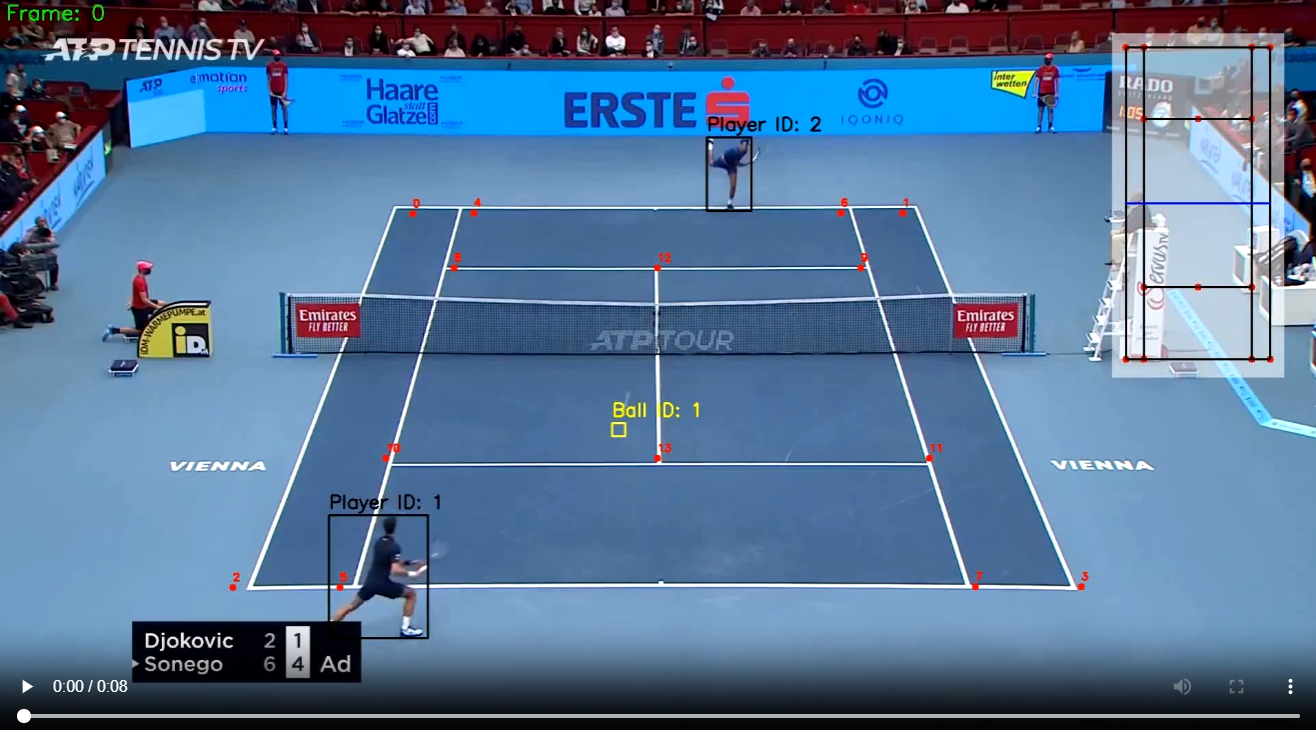
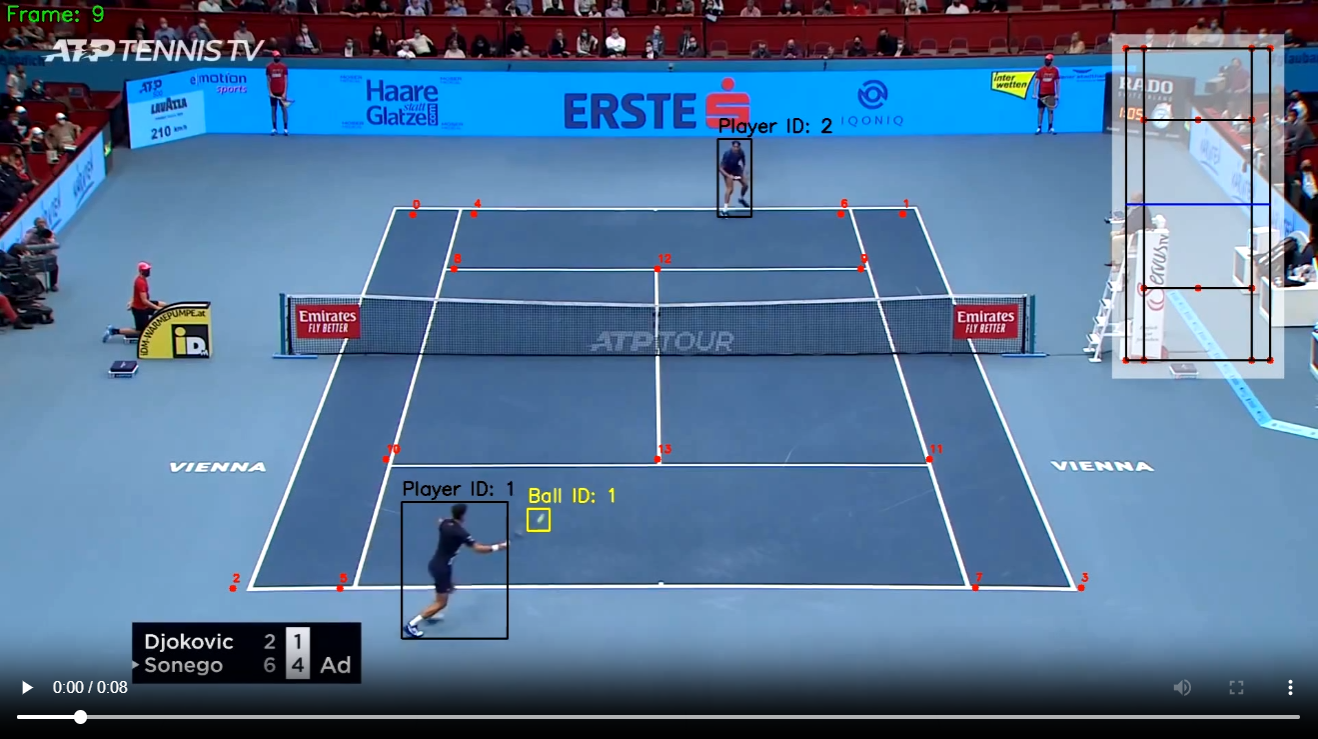
